In [43]:
import pandas as pd
%matplotlib inline
import seaborn as sns

### Import data

In [4]:
mta_2018_df = pd.read_pickle('mta_2018')

In [5]:
# reset mta data index
mta_2018_df.reset_index(drop=True,inplace=True)

# rename column EXITS
mta_2018_df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)

### Find entries for each row

In [6]:
# clean ENTRIES/EXITS as they are cumulative data
mta_2018_df['entries'] = mta_2018_df.ENTRIES.diff()
mta_2018_df['exits'] = mta_2018_df.EXITS.diff()

In [7]:
mta_2018_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2018,00:00:00,REGULAR,6616743,2242108,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2018,04:00:00,REGULAR,6616762,2242113,19.0,5.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2018,08:00:00,REGULAR,6616781,2242144,19.0,31.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2018,12:00:00,REGULAR,6616886,2242229,105.0,85.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2018,16:00:00,REGULAR,6617105,2242278,219.0,49.0


### Using Penn Station data for sanity check
(whether the order of magnitude of the numbers make sense)

can just jump to the end for the plot and see if the numbers (for a single station) are consistent?

In [167]:
# Choose penn station data
penn_df = mta_2018_df[mta_2018_df.STATION == '34 ST-PENN STA'].iloc[1:16554]

# Filter for entries between 0 and 3000
# Outliers come from switching to next turnstiles (should be the same as dropping first rows of each turnstile)
penn_filter = penn_df[(penn_df.entries<3000) & (penn_df.entries>0)].copy()

Check if the value of entries make sense:

In [168]:
penn_filter.entries.min(),penn_filter.entries.mean(),penn_filter.entries.max()

(1.0, 261.16173425078495, 2812.0)

In [169]:
# Combine DATE, TIME to DateTime
penn_filter['DateTime'] = pd.to_datetime(penn_filter['DATE'] + " " + penn_filter['TIME'])
penn_filter.drop(columns=['DATE','TIME'],inplace=True)

In [170]:
# Find time_span (hr) between each row
# Note that most are 4.0 hrs but some are not
penn_filter['time_span (hr)'] = penn_filter.DateTime.diff().apply(lambda x: x.total_seconds()/3600)

In [171]:
# Find ave_entries (entries per hour)
penn_filter['avg_entries'] = penn_filter['entries']/ penn_filter['time_span (hr)']

In [172]:
# Find avg_entries (entries per hour)
penn_filter['avg_entries'] = penn_filter['entries']/ penn_filter['time_span (hr)']

In [173]:
# Check if values of avg_entries make sense
# Found negative values: happens when switching to next turnsiles
penn_filter['avg_entries'].min(), penn_filter['avg_entries'].max()

(-0.76875, 703.0)

In [174]:
# Filter out the negative values (should be the same as dropping first value of each turnstile on a new day)
penn_filter2 = penn_filter[penn_filter.avg_entries >= 0].copy()

In [175]:
# Find median_hour (center of the time slot)
# Corresponds to 2am, 6am, 10am, 14=2pm,...
penn_filter2['median_hour'] = (penn_filter['DateTime'] \
                              - (pd.Timedelta(seconds=penn_filter.iloc[1]['time_span (hr)']*3600)/2)).dt.hour

In [176]:
# Create day_of_week column
penn_filter2['day_of_week'] = penn_filter2.DateTime.apply(lambda x: x.weekday())
# Create Unique Daily ID for each turnstile
penn_filter2['UNIQUEID'] = penn_filter2['STATION'] + '_' + penn_filter2['UNIT'] + '_' + penn_filter2['C/A'] \
+ '_' + penn_filter2['SCP']

In [179]:
penn_filter2.drop(columns=['C/A','UNIT','SCP','LINENAME','DESC','ENTRIES','EXITS'],inplace=True)

In [180]:
penn_filter2

,STATION,DIVISION,entries,exits,DateTime,time_span (hr),avg_entries,median_hour,day_of_week,UNIQUEID
50310,34 ST-PENN STA,IND,28.0,43.0,2018-05-12 08:00:00,4.0,7.00,6,5,34 ST-PENN STA_R012_N067_00-00-00
50311,34 ST-PENN STA,IND,95.0,116.0,2018-05-12 12:00:00,4.0,23.75,10,5,34 ST-PENN STA_R012_N067_00-00-00
50312,34 ST-PENN STA,IND,150.0,150.0,2018-05-12 16:00:00,4.0,37.50,14,5,34 ST-PENN STA_R012_N067_00-00-00
50313,34 ST-PENN STA,IND,105.0,157.0,2018-05-12 20:00:00,4.0,26.25,18,5,34 ST-PENN STA_R012_N067_00-00-00
50314,34 ST-PENN STA,IND,41.0,56.0,2018-05-13 00:00:00,4.0,10.25,22,6,34 ST-PENN STA_R012_N067_00-00-00
...,...,...,...,...,...,...,...,...,...,...
722622,34 ST-PENN STA,IRT,74.0,43.0,2018-06-08 02:00:00,4.0,18.50,0,4,34 ST-PENN STA_R293_R142_01-06-01
722624,34 ST-PENN STA,IRT,100.0,498.0,2018-06-08 10:00:00,8.0,12.50,8,4,34 ST-PENN STA_R293_R142_01-06-01
722625,34 ST-PENN STA,IRT,166.0,283.0,2018-06-08 14:00:00,4.0,41.50,12,4,34 ST-PENN STA_R293_R142_01-06-01
722626,34 ST-PENN STA,IRT,244.0,416.0,2018-06-08 18:00:00,4.0,61.00,16,4,34 ST-PENN STA_R293_R142_01-06-01


In [181]:
# There are 95 turnstiles in Penn station?
penn_filter2.UNIQUEID.nunique()

95

In [182]:
penn_filter2.sort_values('avg_entries',ascending=False)

,STATION,DIVISION,entries,exits,DateTime,time_span (hr),avg_entries,median_hour,day_of_week,UNIQUEID
129862,34 ST-PENN STA,IRT,2812.0,71.0,2018-05-16 10:00:00,4.0,703.000000,8,2,34 ST-PENN STA_R293_R138_00-00-03
129868,34 ST-PENN STA,IRT,2683.0,74.0,2018-05-17 10:00:00,4.0,670.750000,8,3,34 ST-PENN STA_R293_R138_00-00-03
721383,34 ST-PENN STA,IRT,2642.0,106.0,2018-06-04 10:00:00,4.0,660.500000,8,0,34 ST-PENN STA_R293_R138_00-00-03
721299,34 ST-PENN STA,IRT,2602.0,143.0,2018-06-04 10:00:00,4.0,650.500000,8,0,34 ST-PENN STA_R293_R138_00-00-01
721389,34 ST-PENN STA,IRT,2596.0,79.0,2018-06-05 10:00:00,4.0,649.000000,8,1,34 ST-PENN STA_R293_R138_00-00-03
...,...,...,...,...,...,...,...,...,...,...
327806,34 ST-PENN STA,IRT,1.0,0.0,2018-05-22 14:00:00,24.0,0.041667,12,1,34 ST-PENN STA_R293_R138_00-05-00
247942,34 ST-PENN STA,IND,1.0,0.0,2018-05-20 20:00:00,28.0,0.035714,18,6,34 ST-PENN STA_R012_N067_00-06-00
446148,34 ST-PENN STA,IND,1.0,0.0,2018-05-28 04:00:00,28.0,0.035714,2,0,34 ST-PENN STA_R012_N070_04-05-00
51486,34 ST-PENN STA,IND,1.0,0.0,2018-05-14 20:00:00,28.0,0.035714,18,0,34 ST-PENN STA_R012_N070_04-05-00


In [237]:
# Sum over all turnstiles
penn_total = penn_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
penn_total

,day_of_week,median_hour,avg_entries
0,0,0,1899.500000
1,0,2,1297.035714
2,0,4,653.500000
3,0,6,13475.916667
4,0,8,18668.902778
...,...,...,...
78,6,16,6152.975000
79,6,17,1014.856021
80,6,18,16052.398214
81,6,20,5769.910071


In [247]:
# Average over day
penn_total_byday = penn_total.groupby("median_hour")['avg_entries'].mean().reset_index()
penn_total_byday

,median_hour,avg_entries
0,0,2383.458333
1,2,1533.739235
2,4,797.759052
3,6,12233.041588
4,8,16425.948611
5,10,26354.123214
6,12,7898.938690
7,14,18184.689937
8,15,1803.601191
9,16,9496.880815


Text(0, 0.5, 'total entries')

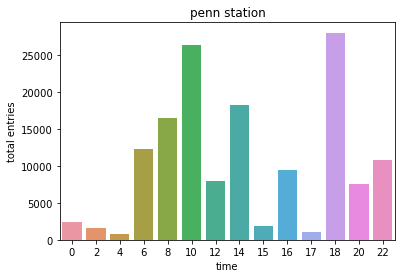

In [242]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_total_byday)
ax.set_title('penn station')
ax.set_xlabel('time')
ax.set_ylabel('total entries')

Text(0, 0.5, 'total entries')

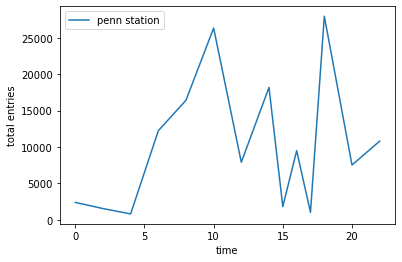

In [243]:
# Same data shown in lineplot (can overlap with data from other stations)
ax = sns.lineplot(x='median_hour', y= 'avg_entries', data = penn_total_byday, label='penn station')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('total entries')

In [262]:
# Day of week daily entries
# Sum over all turnstiles
# penn_total = penn_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()

# Sum over hours for one day
penn_total_byweek = penn_total.groupby("day_of_week")['avg_entries'].sum().reset_index()
penn_total_byweek

,day_of_week,avg_entries
0,0,146395.265873
1,1,173044.834722
2,2,176375.559293
3,3,178262.958048
4,4,165011.173111
5,5,65437.625000
6,6,75606.689306


Text(0, 0.5, 'total entries')

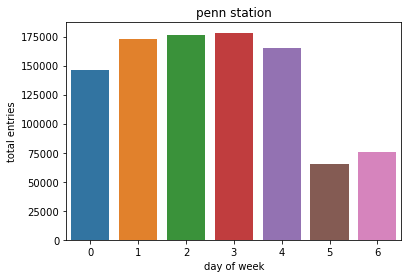

In [277]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='day_of_week', y= 'avg_entries', data = penn_total_byweek)
ax.set_title('penn station')
ax.set_xlabel('day of week')
ax.set_ylabel('total entries')

In [278]:
# weekday/weekend
penn_weekday = penn_filter2[penn_filter2['day_of_week'] < 5]
penn_weekend = penn_filter2[penn_filter2['day_of_week'] >= 5]

In [252]:
penn_weekend

,STATION,DIVISION,entries,exits,DateTime,time_span (hr),avg_entries,median_hour,day_of_week,UNIQUEID
50310,34 ST-PENN STA,IND,28.0,43.0,2018-05-12 08:00:00,4.0,7.00,6,5,34 ST-PENN STA_R012_N067_00-00-00
50311,34 ST-PENN STA,IND,95.0,116.0,2018-05-12 12:00:00,4.0,23.75,10,5,34 ST-PENN STA_R012_N067_00-00-00
50312,34 ST-PENN STA,IND,150.0,150.0,2018-05-12 16:00:00,4.0,37.50,14,5,34 ST-PENN STA_R012_N067_00-00-00
50313,34 ST-PENN STA,IND,105.0,157.0,2018-05-12 20:00:00,4.0,26.25,18,5,34 ST-PENN STA_R012_N067_00-00-00
50314,34 ST-PENN STA,IND,41.0,56.0,2018-05-13 00:00:00,4.0,10.25,22,6,34 ST-PENN STA_R012_N067_00-00-00
...,...,...,...,...,...,...,...,...,...,...
722593,34 ST-PENN STA,IRT,9.0,7.0,2018-06-03 06:00:00,4.0,2.25,4,6,34 ST-PENN STA_R293_R142_01-06-01
722594,34 ST-PENN STA,IRT,46.0,67.0,2018-06-03 10:00:00,4.0,11.50,8,6,34 ST-PENN STA_R293_R142_01-06-01
722595,34 ST-PENN STA,IRT,120.0,173.0,2018-06-03 14:00:00,4.0,30.00,12,6,34 ST-PENN STA_R293_R142_01-06-01
722596,34 ST-PENN STA,IRT,115.0,271.0,2018-06-03 18:00:00,4.0,28.75,16,6,34 ST-PENN STA_R293_R142_01-06-01


In [260]:
# Weekday data
# Sum over all turnstiles
penn_weekday_total = penn_weekday.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
# Average over day
penn_weekday_total_byday = penn_weekday_total.groupby("median_hour")['avg_entries'].mean().reset_index()
# penn_weekday_total_byday

Text(0, 0.5, 'total entries')

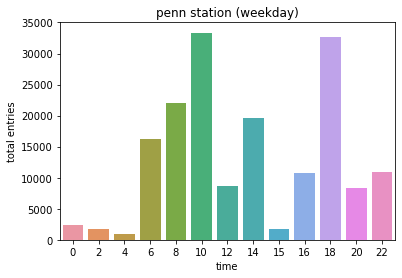

In [257]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_weekday_total_byday)
ax.set_title('penn station (weekday)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')

In [271]:
# Weekend data
# Sum over all turnstiles
penn_weekend_total = penn_weekend.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
# Average over day
penn_weekend_total_byday = penn_weekend_total.groupby("median_hour")['avg_entries'].mean().reset_index()
# penn_weekend_total_byday

Text(0, 0.5, 'total entries')

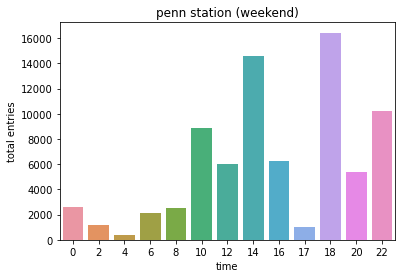

In [272]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_weekend_total_byday)
ax.set_title('penn station (weekend)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')